## Accesibilidad usando la red de calles

En este ejercicio vamos a utilizar la matriz de costos que calculamos utilizando la red de calles para generar modelos de accesibilidad y compararlos con los que obtuvimos utilizando las distancias euclidianas.

Ya tenemos preparados todos los datos, entonces todo será relativamente simple. Lo primero que vamos a hacer es leer los datos de oferta y demanda

In [18]:
import pandas as pd
import geopandas as gpd
from access import Access, weights
import matplotlib.pyplot as plt
import contextily as ctx

In [7]:
agebs_zmvm_centroides = pd.read_pickle("datos/agebs_zmvm_centroides.pkl")
areas_verdes_centroides = pd.read_pickle("datos/areas_verdes_centroides.pkl")

Ahora leemos la matriz de costos

In [5]:
costos = pd.read_pickle("datos/matriz_od_walking.pkl")
costos.head()

,destino,costo,origen
0,7596,47966.0,0901000011716
1,7597,50259.6,0901000011716
2,7598,47036.7,0901000011716
3,7599,47065.8,0901000011716
4,7600,46993.3,0901000011716


Igual que en el primer ejemplo, instanciamos el objeto `access`

In [11]:
accesibilidad_red = Access(demand_df            = agebs_zmvm_centroides,
                           demand_index         = 'CVEGEO',
                           demand_value         = 'POBTOT',
                           supply_df            = areas_verdes_centroides,
                           supply_index         = 'id_parque',
                           supply_value         = 'area',
                           cost_df              = costos,
                           cost_origin          = 'origen',
                           cost_dest            = 'destino',
                           cost_name            = 'costo',
                           neighbor_cost_df     = costos,
                           neighbor_cost_origin = 'origen',
                           neighbor_cost_dest   = 'destino',
                           neighbor_cost_name   = 'costo')

Definimos la función de peso para el modelo gravitatorio

In [10]:
gravity = weights.gravity(scale = 750, alpha = -1)

Calculamos los mismos dos modelos de accesibilidad

In [12]:
accesibilidad_red.weighted_catchment(name="gravity", weight_fn=gravity)
accesibilidad_red.raam(name="raam", tau=750)

,raam_area
CVEGEO,
0900200010010,1.806327
0900200010025,1.618977
090020001003A,1.500436
0900200010044,1.489735
0900200010097,1.680111
...,...
1512500010016,7.345888
1512500010020,7.073884
151250001004A,7.783193


Recordemos ráído lo que nos regresan los cálculos

In [13]:
accesibilidad_red.norm_access_df

,gravity_area,raam_area
CVEGEO,,
0900200010010,1.178225,0.342215
0900200010025,1.190089,0.306721
090020001003A,1.195264,0.284263
0900200010044,1.357735,0.282235
0900200010097,1.204622,0.318303
...,...,...
1512500010016,0.504243,1.391704
1512500010020,0.500703,1.340172
151250001004A,0.493714,1.474553


Podemos hacer rápido un par de mapas comparativos

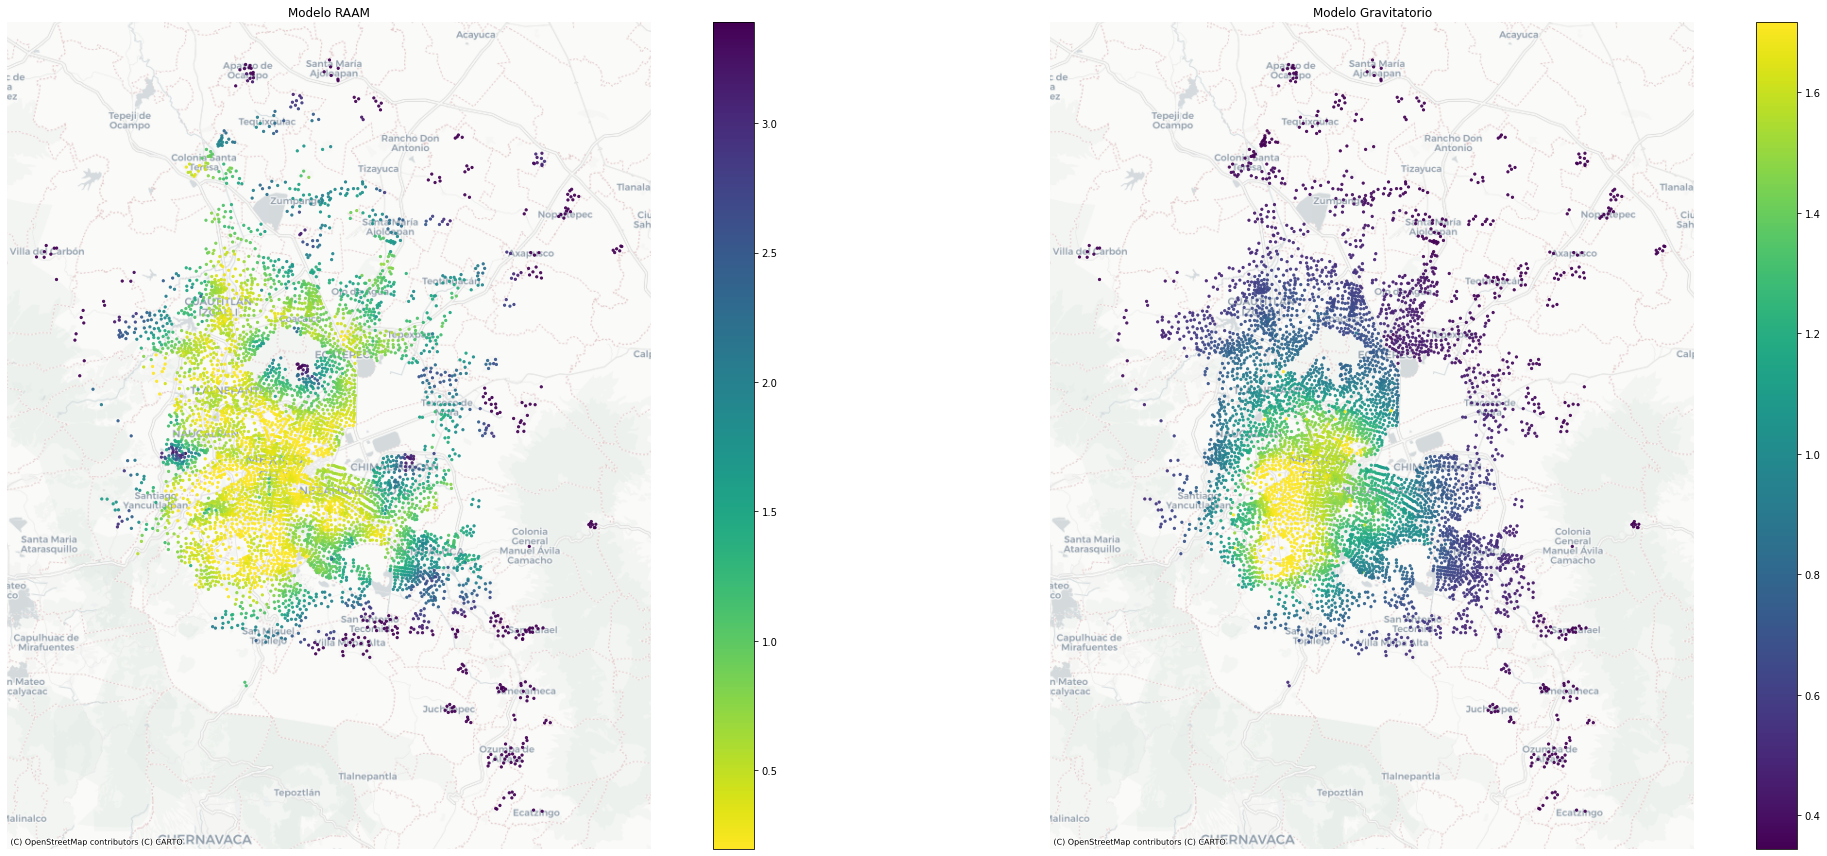

In [28]:
mapa_accesibilidad = agebs_zmvm_centroides.set_index('CVEGEO')[['geometry']].join(accesibilidad_red.norm_access_df, how = "inner")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32,12))
ax1 = mapa_accesibilidad.to_crs(epsg=3857).plot('raam_area', legend = True,
                                                cmap =  "viridis_r", 
                                                markersize = 5, alpha = 0.9, ax = ax1,
                                                vmin = mapa_accesibilidad['raam_area'].quantile(0.05), 
                                                vmax = mapa_accesibilidad['raam_area'].quantile(0.95),
                                                )
ax1.set_axis_off()
ax1.set(title='Modelo RAAM')
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)

ax2 = mapa_accesibilidad.to_crs(epsg=3857).plot('gravity_area', legend = True,
                                                cmap =  "viridis", 
                                                markersize = 5, alpha = 0.9, ax = ax2,
                                                vmin = mapa_accesibilidad['gravity_area'].quantile(0.05), 
                                                vmax = mapa_accesibilidad['gravity_area'].quantile(0.95),
                                                )
ax2.set_axis_off()
ax2.set(title='Modelo Gravitatorio')
# plt.subplots_adjust(wspace=-.5, hspace=0)
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
plt.tight_layout()

## Comparación con distancia euclidiana

Ahora vamos a comparar los modelos que calculamos usando la distancia euclidiana con los que obtuvimos ahora. Los resultados anteriores están guardados como csv en `datos/accesibilidad_distancia_euclidiana.csv`.

In [20]:
accesibilidad_euclidiana = pd.read_csv("datos/accesibilidad_distancia_euclidiana.csv")
accesibilidad_euclidiana

,CVEGEO,gravity_area,raam_area
0,0900200010010,1.214146,0.410899
1,0900200010025,1.258734,0.344277
2,090020001003A,1.243373,0.354772
3,0900200010044,1.340166,0.321299
4,0900200010097,1.297670,0.290006
...,...,...,...
5753,1512500010016,0.565422,1.455764
5754,1512500010020,0.575081,1.345631
5755,151250001004A,0.559120,1.541626
5756,1512500070054,0.614837,1.143446


Lo primero que podemos hacer es unos mapas para comparar visualmente los resultados. Para esto lo mejor es hacer una función que haga cada mapa

In [38]:
def haz_mapa(datos, ax, columna, titulo, swap_colors=True):
    if swap_colors:
        swap_colors = "raam" in columna
    ax = datos.to_crs(epsg=3857).plot(columna, 
                                      legend = True,
                                      cmap = "viridis_r" if swap_colors else "viridis", 
                                      markersize = 5, alpha = 0.9, ax = ax,
                                      vmin = datos[columna].quantile(0.05), 
                                      vmax = datos[columna].quantile(0.95),
                                      )
    ax.set_axis_off()
    ax.set(title=titulo)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

Con esta función es fácil hacer todos los mapas en una misma figura, pero primero necesitamos tener los resultados originales ligados a las geometrías de los puntos. Lo más fácil es tener todo en un sólo dataframe, claro que eso implica cambiar los nombres de las columnas

In [29]:
mapa_accesibilidad = mapa_accesibilidad.rename({'gravity_area': 'gravity_area_red', 'raam_area': 'raam_area_red'}, axis=1)
mapa_accesibilidad = mapa_accesibilidad.merge(accesibilidad_euclidiana, on='CVEGEO')
mapa_accesibilidad = mapa_accesibilidad.rename({'gravity_area': 'gravity_area_euclidiana', 'raam_area': 'raam_area_euclidiana'}, axis=1)
mapa_accesibilidad

,CVEGEO,geometry,gravity_area_red,raam_area_red,gravity_area_euclidiana,raam_area_euclidiana
0,0901000011716,POINT (2787091.708 816590.463),1.181068,0.469373,1.352278,0.457984
1,0901000012150,POINT (2793986.972 823047.548),1.747578,0.407484,1.827260,0.433662
2,0901000011133,POINT (2794967.016 819439.549),1.974609,0.075041,2.093960,0.075893
3,0901000011307,POINT (2792230.506 815397.361),1.877158,0.115275,2.172756,0.130912
4,0901000010281,POINT (2788669.707 823554.634),NaN,0.328488,1.583440,0.251911
...,...,...,...,...,...,...
5753,151250001004A,POINT (2808504.425 857540.602),0.493714,1.474553,0.559120,1.541626
5754,1512500010016,POINT (2807986.700 857448.943),0.504243,1.391704,0.565422,1.455764
5755,1512500010020,POINT (2807958.932 857067.980),0.500703,1.340172,0.575081,1.345631
5756,1512500070054,POINT (2806373.386 856257.252),0.511780,1.256242,0.614837,1.143446


Ahora sí podemos hacer todos los mapas

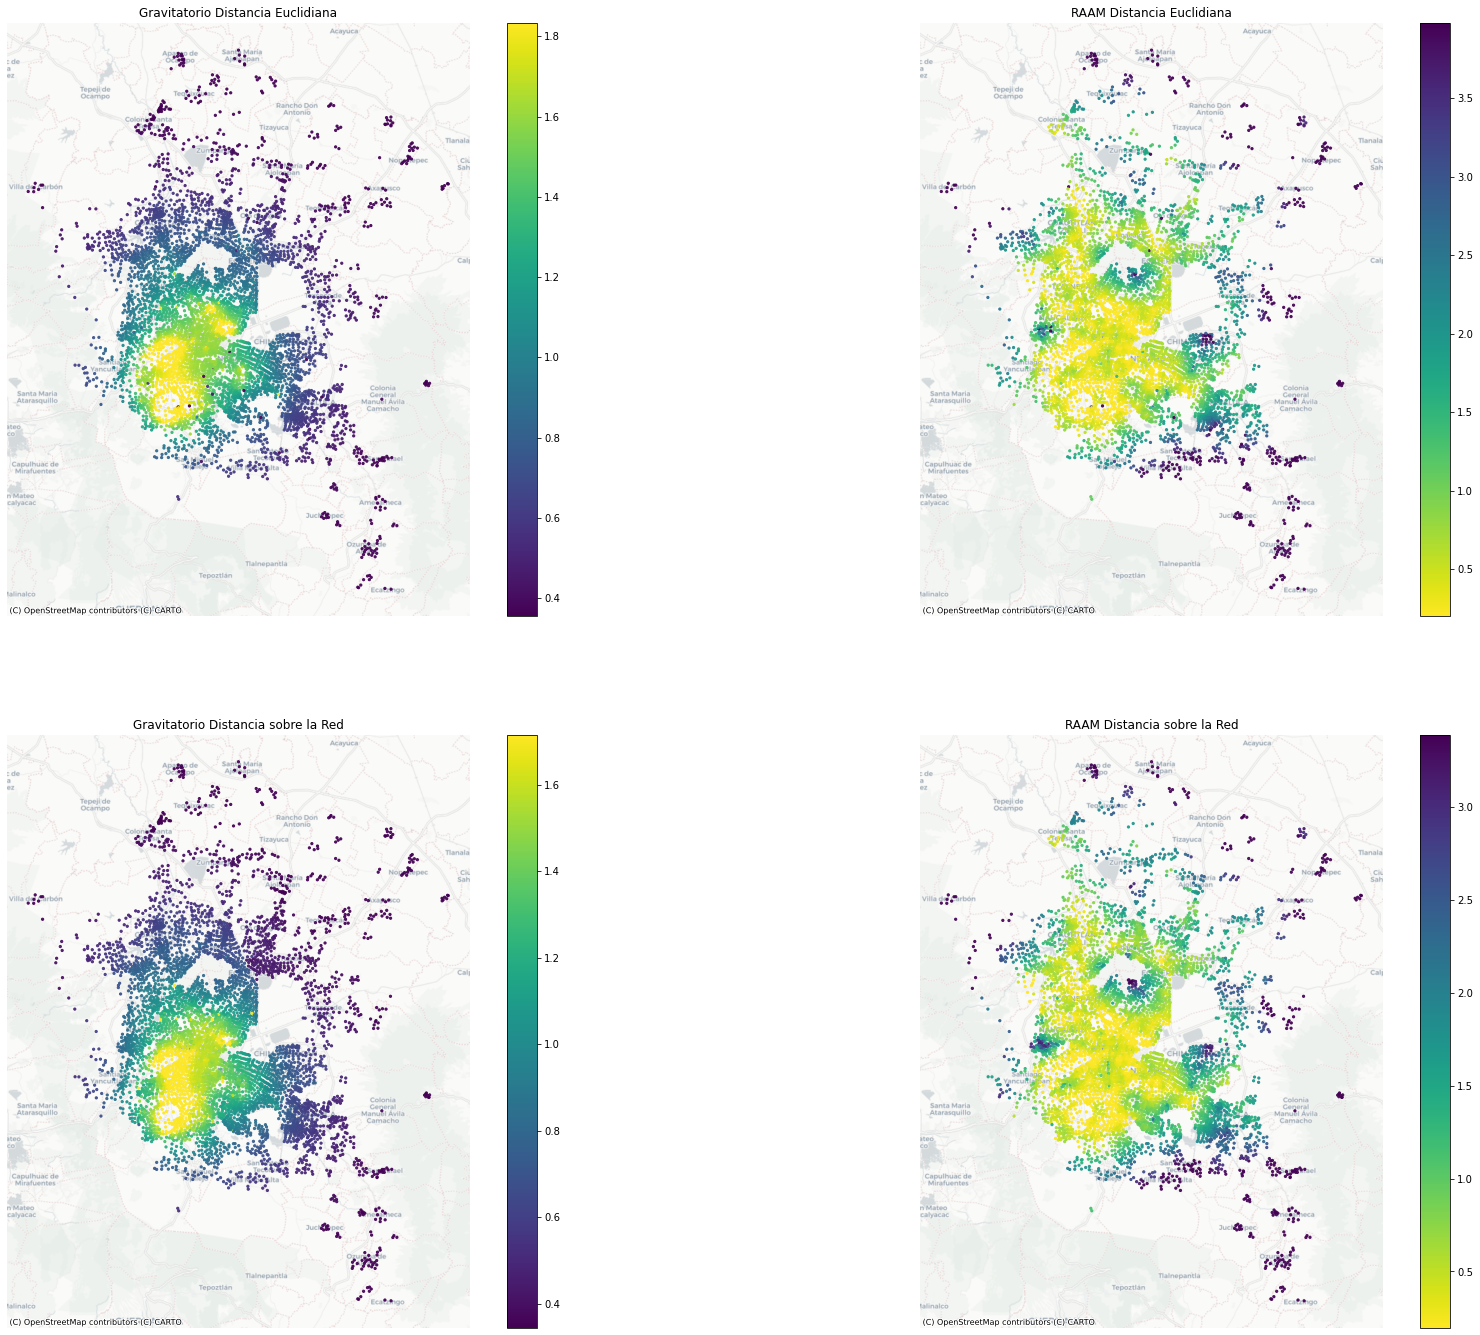

In [39]:
titulos_columnas = {'gravity_area_euclidiana': 'Gravitatorio Distancia Euclidiana',
                    'raam_area_euclidiana': 'RAAM Distancia Euclidiana',
                    'gravity_area_red': 'Gravitatorio Distancia sobre la Red',
                    'raam_area_red': 'RAAM Distancia sobre la Red'}
fig, axes = plt.subplots(2,2,figsize=(30,24))
axes = axes.ravel()
for i, columna in enumerate(titulos_columnas.keys()):
    haz_mapa(mapa_accesibilidad, axes[i], columna, titulos_columnas[columna])

Son muy parecidos, pero no exáctamente iguales, podemos calcular las diferencias en los valores de accesibilidad por modelo y hacer mapas de las diferencias

In [34]:
mapa_accesibilidad['dif_gravity'] = mapa_accesibilidad['gravity_area_euclidiana'] - mapa_accesibilidad['gravity_area_red']
mapa_accesibilidad['dif_raam'] = mapa_accesibilidad['raam_area_euclidiana'] - mapa_accesibilidad['raam_area_red']
mapa_accesibilidad

,CVEGEO,geometry,gravity_area_red,raam_area_red,gravity_area_euclidiana,raam_area_euclidiana,dif_gravity,dif_raam
0,0901000011716,POINT (2787091.708 816590.463),1.181068,0.469373,1.352278,0.457984,0.171210,-0.011390
1,0901000012150,POINT (2793986.972 823047.548),1.747578,0.407484,1.827260,0.433662,0.079682,0.026177
2,0901000011133,POINT (2794967.016 819439.549),1.974609,0.075041,2.093960,0.075893,0.119351,0.000853
3,0901000011307,POINT (2792230.506 815397.361),1.877158,0.115275,2.172756,0.130912,0.295598,0.015637
4,0901000010281,POINT (2788669.707 823554.634),NaN,0.328488,1.583440,0.251911,NaN,-0.076577
...,...,...,...,...,...,...,...,...
5753,151250001004A,POINT (2808504.425 857540.602),0.493714,1.474553,0.559120,1.541626,0.065406,0.067073
5754,1512500010016,POINT (2807986.700 857448.943),0.504243,1.391704,0.565422,1.455764,0.061179,0.064060
5755,1512500010020,POINT (2807958.932 857067.980),0.500703,1.340172,0.575081,1.345631,0.074378,0.005459
5756,1512500070054,POINT (2806373.386 856257.252),0.511780,1.256242,0.614837,1.143446,0.103057,-0.112795


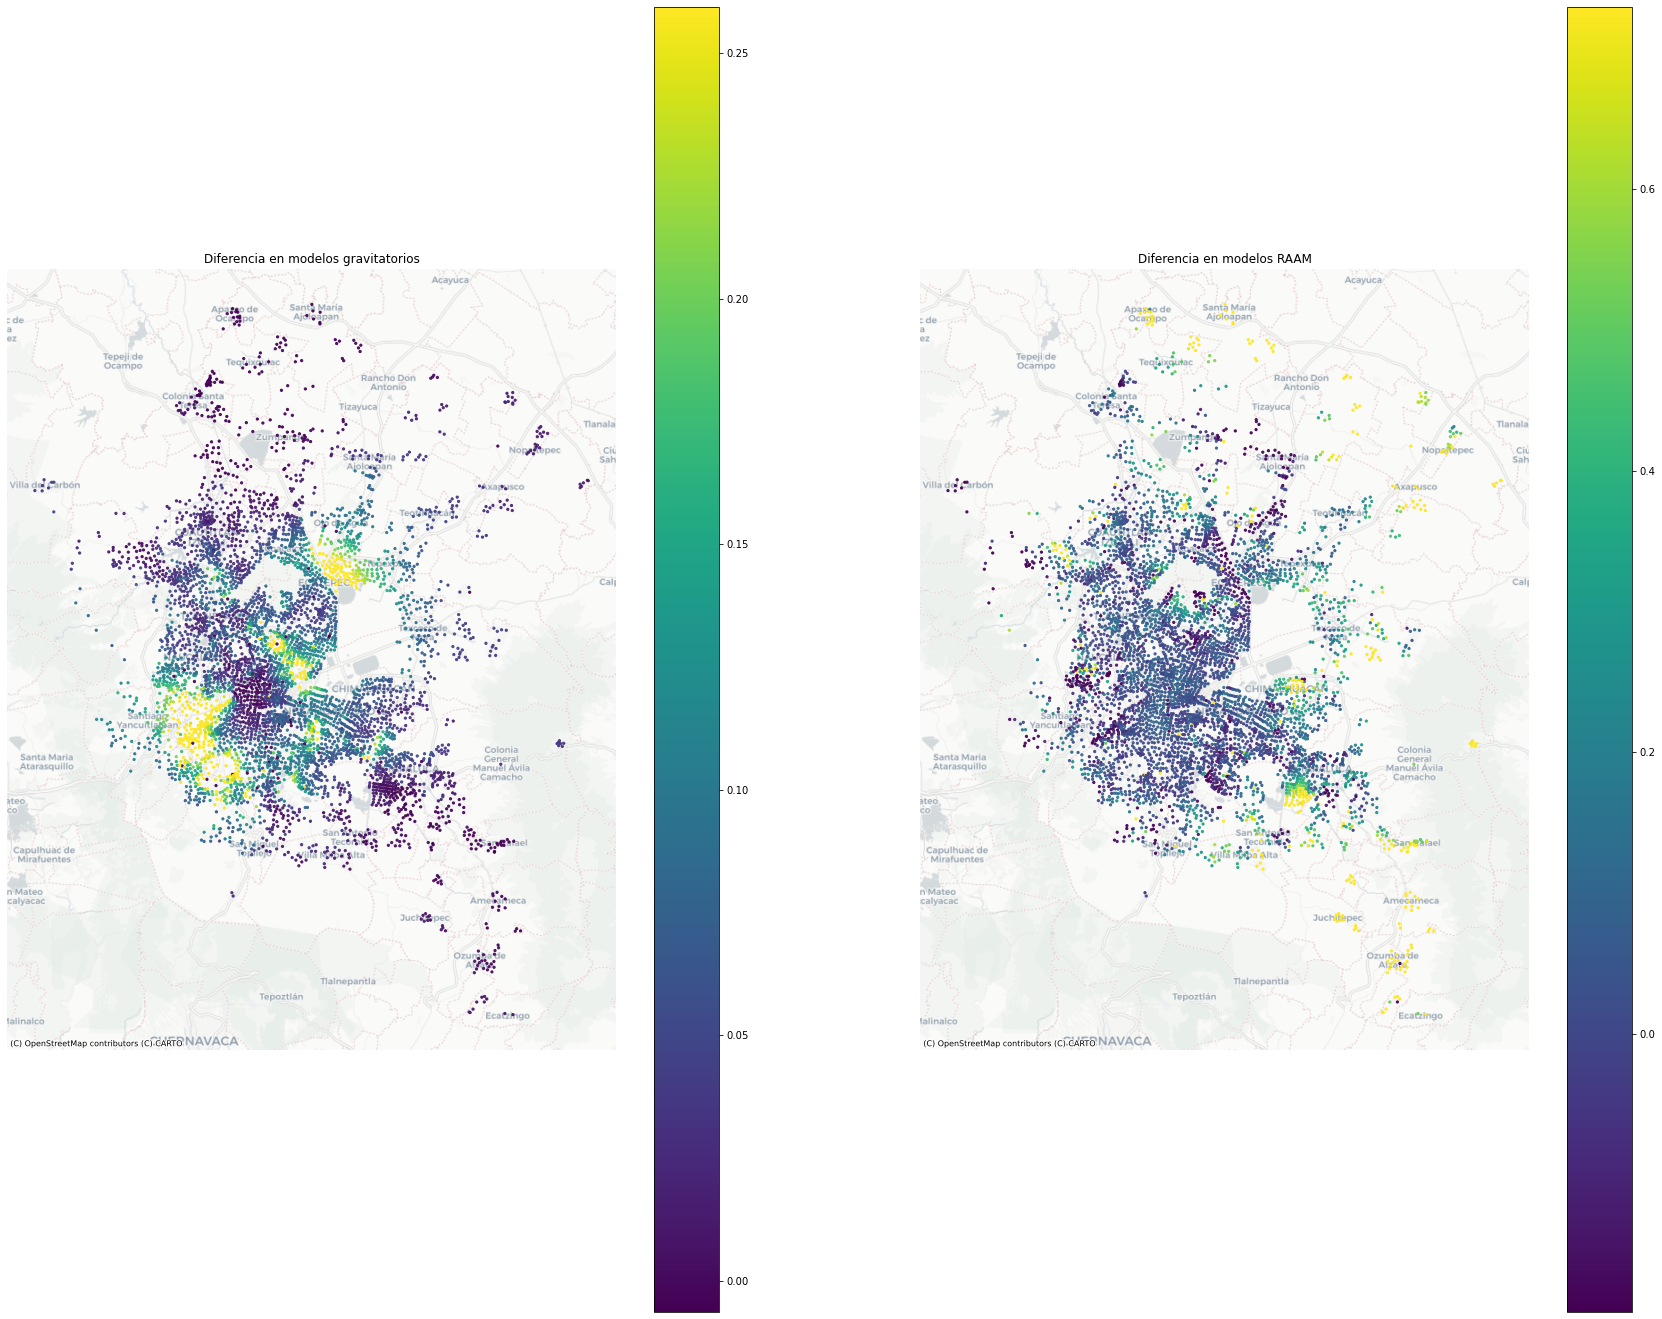

In [40]:
titulos_columnas = {'dif_gravity': 'Diferencia en modelos gravitatorios',
                    'dif_raam': 'Diferencia en modelos RAAM'
                   }
fig, axes = plt.subplots(1,2,figsize=(30,24))
axes = axes.ravel()
for i, columna in enumerate(titulos_columnas.keys()):
    haz_mapa(mapa_accesibilidad, axes[i], columna, titulos_columnas[columna], swap_colors=False)